In [1]:
import sys
sys.path.append("..")

from connector.cnxn import server_access
import backtrader as bt
import pandas as pd
from backtrader.feeds import PandasData
import quantstats

In [2]:
engine = server_access()
grvy_df_sql = '''  select [date], [open], [high], [Low], adjClose [close], volume
from [dbo].[tbl_historical_prices] where ticker = 'GRVY'
and year(date) = 2016
order by date asc
  
'''
grvy_df = pd.read_sql(grvy_df_sql, engine)
grvy_df['predicted'] = 0
grvy_df['predicted'].iloc[0] = 1
grvy_df['predicted'].iloc[-1] = -1

D:\Work\stocks_research\venv\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [3]:
veon_df_sql = '''  select [date], [open], [high], [Low], adjClose [close], volume
from [dbo].[tbl_historical_prices] where ticker = 'VEON'
and year(date) = 2016
order by date asc
  
'''
veon_df = pd.read_sql(veon_df_sql, engine)
veon_df['predicted'] = 0
veon_df['predicted'].iloc[0] = 1
veon_df['predicted'].iloc[-1] = -1

In [4]:
grvy_df = grvy_df.fillna(0)
veon_df = veon_df.fillna(0)

In [5]:
grvy_df.set_index('date', inplace=True)
veon_df.set_index('date', inplace=True)

In [6]:
veon_df.head()

,open,high,Low,close,volume,predicted
date,,,,,,
2016-01-04,3.16,3.31,3.14,2.4680,1737600.0,1
2016-01-05,3.30,3.42,3.26,2.5658,2332800.0,0
2016-01-06,3.30,3.34,3.21,2.4529,2335000.0,0
2016-01-07,3.18,3.22,3.11,2.3551,3706900.0,0
2016-01-08,3.18,3.22,3.06,2.3400,2544400.0,0


In [7]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    OHLCV = ['open', 'high', 'low', 'close', 'volume']
    cols = OHLCV + ['predicted']
    # create lines
    lines = tuple(cols)
    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [8]:
class MagicFormulaStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.data_predicted_grvy = self.datas[0].predicted
        self.data_open_grvy = self.datas[0].open
        self.data_close_grvy = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        #  self.log('Close, %.2f' % self.dataclose[0])
        if not self.position:
            if self.data_predicted_grvy == 1:
                close_grvy = self.data_close_grvy[0]
                print(close_grvy)
                self.size_buy_grvy = round((
                            (self.broker.get_cash() * 0.5 / close_grvy)
                    ),0)
                self.log('NUMBER OF SHARES , %.2f' % self.size_buy_grvy)
                self.log('BUY CREATE, %.2f' % close_grvy)
                self.buy(size=1)
                
                
        else:
            if self.data_predicted_grvy == -1:
                close_grvy = self.data_close_grvy[0]
                self.log('SELL CREATE, %.2f' % close_grvy)
                self.close()

            

Starting Portfolio Value: 1000.00
1.625
2016-01-04, NUMBER OF SHARES , 308.00
2016-01-04, BUY CREATE, 1.62
2016-12-30, SELL CREATE, 5.28
Final Portfolio Value: 1003.62


<IPython.core.display.Javascript object>


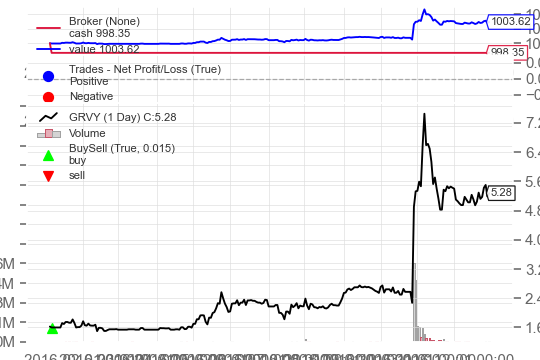

[[<Figure size 432x288 with 4 Axes>]]

In [9]:
data = SignalData(dataname=grvy_df)
cerebro = bt.Cerebro(cheat_on_open=True)
cerebro.addstrategy(MagicFormulaStrategy)
cerebro.broker.setcash(1000)
cerebro.broker.setcommission(commission=0.0)
cerebro.adddata(data, name='GRVY')
cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")


print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

results = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.plot()

In [10]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

<IPython.core.display.Javascript object>


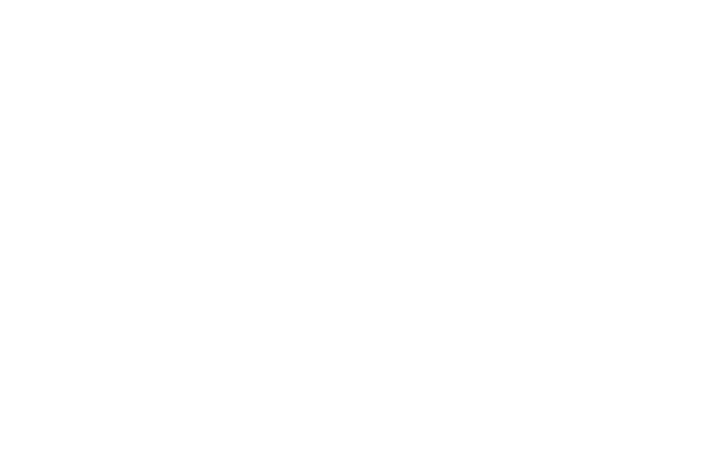

<IPython.core.display.Javascript object>


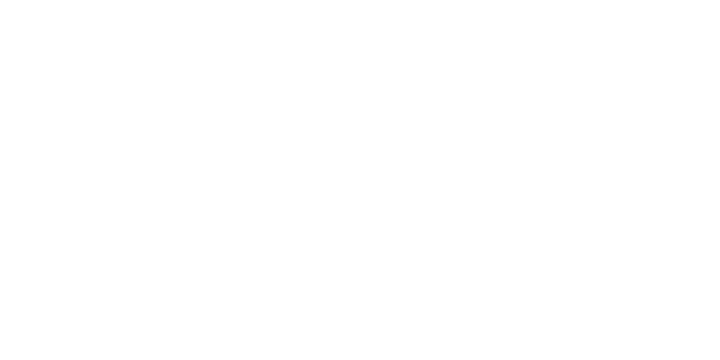

<IPython.core.display.Javascript object>


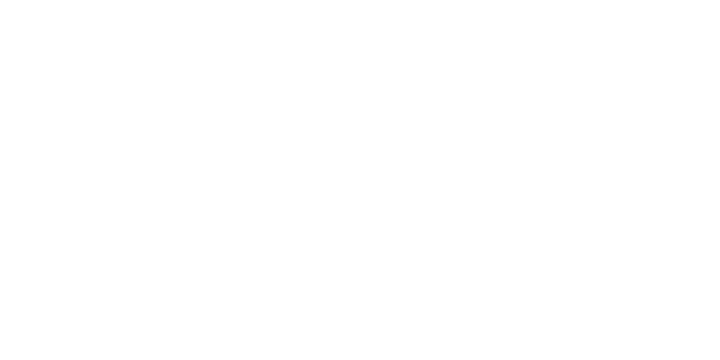

<IPython.core.display.Javascript object>


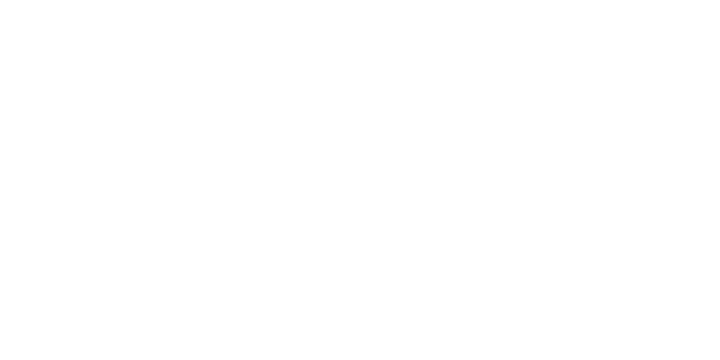

<IPython.core.display.Javascript object>


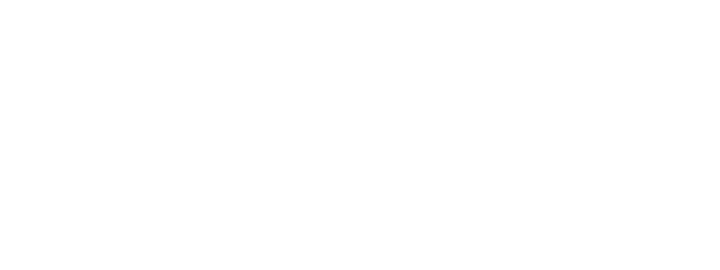

<IPython.core.display.Javascript object>


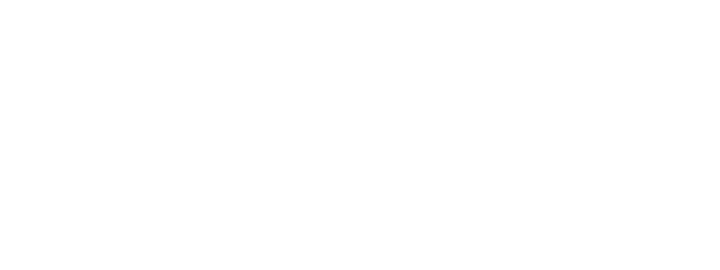

<IPython.core.display.Javascript object>


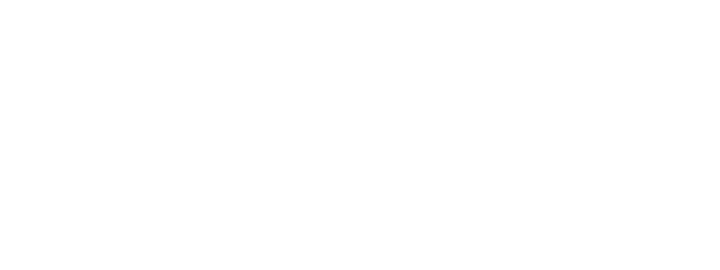

<IPython.core.display.Javascript object>


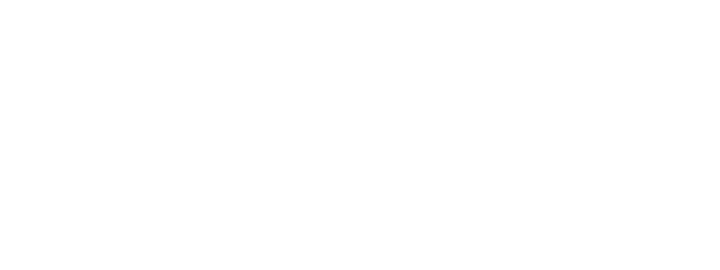

<IPython.core.display.Javascript object>


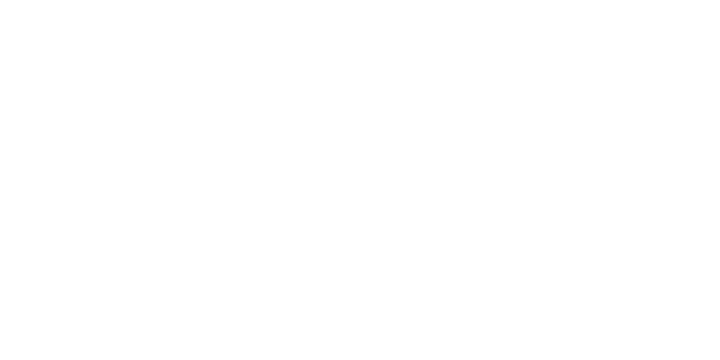

<IPython.core.display.Javascript object>


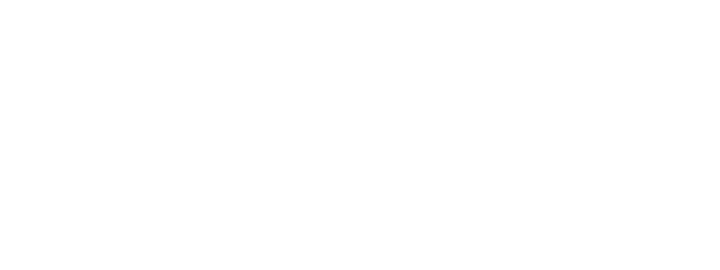

<IPython.core.display.Javascript object>


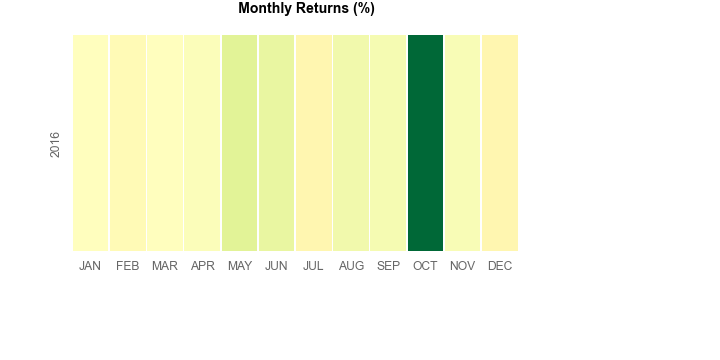

<IPython.core.display.Javascript object>


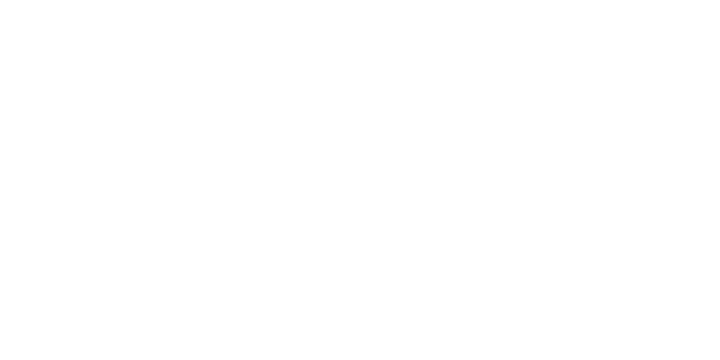

In [11]:
returns.index = returns.index.tz_convert(None)

quantstats.reports.html(returns, output=r'Stats2.html', title="Gravity Co")

In [12]:
pyfoliozer.get_pf_items()[1]

,GRVY,cash
Datetime,,
2016-01-04 00:00:00+00:00,0.000,1000.00
2016-01-05 00:00:00+00:00,1.600,998.35
2016-01-06 00:00:00+00:00,1.600,998.35
2016-01-07 00:00:00+00:00,1.600,998.35
2016-01-08 00:00:00+00:00,1.600,998.35
...,...,...
2016-12-23 00:00:00+00:00,5.175,998.35
2016-12-27 00:00:00+00:00,5.425,998.35
2016-12-28 00:00:00+00:00,5.500,998.35


In [13]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2016-01-05 00:00:00+00:00,1,1.65,0,GRVY,-1.65
